In [ ]:
#| default_exp mis_val_utility

# Missing Values Utilities


> Comprehensive tools for visualizing and analyzing missing data patterns.

Overview
This notebook is part of the project_utility package and provides tools for visualizing and analyzing missing data in pandas DataFrames. The tools focus on providing multiple complementary views of missing data patterns to help guide data cleaning and preprocessing.
Imports

In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Union, Tuple, Any


# Missing value visualization
import missingno as msno

# Handle warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Missing Values Analysis Class


>This class provides a unified interface for visualizing missing data patterns.

In [ ]:
#| export
class MissingValuesAnalyzer:
    """
    A class for visualizing and analyzing missing data in pandas DataFrames.
    
    Attributes:
    -----------
    df : pandas DataFrame
        Input dataframe to analyze
    """
    
    def __init__(self, df: pd.DataFrame):
        """
        Initialize MissingValuesAnalyzer with a dataframe.
        
        Parameters:
        -----------
        df : pandas DataFrame
            Input dataframe to analyze
        """
        self.df = df
        self.missing_summary = self._generate_missing_summary()
    
    def _generate_missing_summary(self) -> Dict[str, Any]:
        """
        Generate summary statistics about missing values.
        
        Returns:
        --------
        dict
            Dictionary containing summary statistics
        """
        # Overall statistics
        total_cells = self.df.size
        missing_cells = self.df.isna().sum().sum()
        missing_percentage = (missing_cells / total_cells) * 100
        
        # By column
        col_stats = pd.DataFrame({
            'missing_count': self.df.isna().sum(),
            'missing_percentage': (self.df.isna().sum() / len(self.df) * 100)
        }).sort_values('missing_count', ascending=False)
        
        # By row
        row_stats = pd.DataFrame({
            'missing_count': self.df.isna().sum(axis=1),
            'missing_percentage': (self.df.isna().sum(axis=1) / self.df.shape[1] * 100)
        })
        
        # Calculate mean values (for scatter plot)
        try:
            row_stats['log2_mean'] = np.log2(self.df.mean(axis=1, skipna=True))
        except:
            row_stats['log2_mean'] = np.nan
            print("Warning: Could not calculate log2 mean values. Non-numeric data may be present.")
        
        # Value counts of missing counts per row
        missing_counts_dist = self.df.isna().sum(axis=1).value_counts().sort_index()
        
        return {
            'total_cells': total_cells,
            'missing_cells': missing_cells,
            'missing_percentage': missing_percentage,
            'column_stats': col_stats,
            'row_stats': row_stats,
            'missing_counts_dist': missing_counts_dist
        }
    
    def plot_missing_matrix(self, ax=None, **kwargs):
        """
        Plot a matrix visualization of missing values.
        
        Parameters:
        -----------
        ax : matplotlib.axes.Axes, optional
            Axes to plot on
        **kwargs : 
            Additional arguments to pass to msno.matrix
            
        Returns:
        --------
        matplotlib.axes.Axes
            The axes containing the plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        # Use missingno to create matrix plot
        msno.matrix(self.df, ax=ax, **kwargs)
        
        # Adjust title and styling
        ax.set_title("Missing Values Matrix", fontsize=14)
        ax.set_xlabel("Features", fontsize=12)
        ax.set_ylabel("Samples", fontsize=12)
        
        return ax
    
    def plot_missing_dendrogram(self, ax=None, orientation='right', **kwargs):
        """
        Plot a dendrogram of missing value correlations.
        
        Parameters:
        -----------
        ax : matplotlib.axes.Axes, optional
            Axes to plot on
        orientation : str
            Orientation of the dendrogram ('top', 'right', 'bottom', or 'left')
        **kwargs : 
            Additional arguments to pass to msno.dendrogram
            
        Returns:
        --------
        matplotlib.axes.Axes
            The axes containing the plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        # Use missingno to create dendrogram
        msno.dendrogram(self.df, ax=ax, orientation=orientation, **kwargs)
        
        # Adjust title and styling
        ax.set_title("Missing Values Correlation Dendrogram", fontsize=14)
        
        return ax
    
    def plot_missing_counts_distribution(self, ax=None, **kwargs):
        """
        Plot the distribution of missing value counts per row.
        
        Parameters:
        -----------
        ax : matplotlib.axes.Axes, optional
            Axes to plot on
        **kwargs : 
            Additional arguments to pass to plot
            
        Returns:
        --------
        matplotlib.axes.Axes
            The axes containing the plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get the distribution
        dist = self.missing_summary['missing_counts_dist']
        
        # Plot as bar chart
        dist.plot(kind='bar', ax=ax, color='#3498db', **kwargs)
        
        # Adjust title and styling
        ax.set_title("Distribution of Missing Values per Sample", fontsize=14)
        ax.set_xlabel("Number of Missing Values", fontsize=12)
        ax.set_ylabel("Count of Samples", fontsize=12)
        
        # Add counts above bars
        for i, count in enumerate(dist):
            ax.text(i, count + (max(dist) * 0.02), str(count), ha='center')
        
        return ax
    
    def plot_missing_vs_mean(self, ax=None, **kwargs):
        """
        Plot the relationship between missing values and feature means.
        
        Parameters:
        -----------
        ax : matplotlib.axes.Axes, optional
            Axes to plot on
        **kwargs : 
            Additional arguments to pass to scatter
            
        Returns:
        --------
        matplotlib.axes.Axes
            The axes containing the plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        # Get the data
        row_stats = self.missing_summary['row_stats']
        
        # Set default scatter point size
        kwargs.setdefault('s', 10)
        kwargs.setdefault('alpha', 0.5)
        
        # Plot scatter
        ax.scatter(
            row_stats['log2_mean'], 
            row_stats['missing_count'],
            color='#e74c3c',
            **kwargs
        )
        
        # Adjust title and styling
        ax.set_title("Missing Values vs. Log2 Mean", fontsize=14)
        ax.set_xlabel("Log2 Mean Value", fontsize=12)
        ax.set_ylabel("Number of Missing Values", fontsize=12)
        ax.grid(True, alpha=0.3)
        
        return ax
    
    def plot_missing_dashboard(self, figsize=(14, 12)):
        """
        Create a comprehensive dashboard of missing value visualizations.
        
        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height) in inches
            
        Returns:
        --------
        tuple
            (figure, axes) - The matplotlib figure and axes objects
        """
        # Create figure and axes
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f"Missing Values Analysis - {self.df.shape[0]} samples × {self.df.shape[1]} features", 
                    fontsize=16, y=0.98)
        
        # Add some space between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        
        # 1. Matrix plot (top left)
        self.plot_missing_matrix(ax=axes[0, 0], sparkline=False)
        
        # 2. Dendrogram (top right)
        self.plot_missing_dendrogram(ax=axes[0, 1], orientation='right')
        
        # 3. Missing counts distribution (bottom left)
        self.plot_missing_counts_distribution(ax=axes[1, 0])
        
        # 4. Missing vs mean (bottom right)
        self.plot_missing_vs_mean(ax=axes[1, 1])
        
        # Add overall statistics as text
        stats_text = (
            f"Overall Missing: {self.missing_summary['missing_percentage']:.2f}% "
            f"({self.missing_summary['missing_cells']} of {self.missing_summary['total_cells']} cells)\n"
            f"Samples with no missing data: {(self.missing_summary['row_stats']['missing_count'] == 0).sum()} "
            f"({(self.missing_summary['row_stats']['missing_count'] == 0).sum() / len(self.df) * 100:.1f}%)"
        )
        plt.figtext(0.5, 0.01, stats_text, ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        return fig, axes, self.missing_summary

In [ ]:
# Create a DataFrame with missing values
def create_sample_df(n_rows=1000, n_cols=50, missing_fraction=0.2, random_seed=42):
    """Create a sample DataFrame with controlled missing values."""
    np.random.seed(random_seed)
    
    # Create a DataFrame with random values
    df = pd.DataFrame(np.random.lognormal(0, 1, size=(n_rows, n_cols)))
    
    # Add column names
    df.columns = [f'feature_{i}' for i in range(n_cols)]
    
    # Add row names
    df.index = [f'sample_{i}' for i in range(n_rows)]
    
    # Create patterns of missing values
    
    # 1. Completely random missing values
    mask_random = np.random.random(size=df.shape) < (missing_fraction / 2)
    
    # 2. Structured missing values - some features have more missing values
    mask_cols = np.zeros(df.shape, dtype=bool)  # Explicitly use boolean dtype
    cols_with_missing = np.random.choice(n_cols, size=int(n_cols * 0.3), replace=False)
    mask_cols[:, cols_with_missing] = np.random.random(size=(n_rows, len(cols_with_missing))) < missing_fraction
    
    # 3. Structured missing values - some samples have more missing values
    mask_rows = np.zeros(df.shape, dtype=bool)  # Explicitly use boolean dtype
    rows_with_missing = np.random.choice(n_rows, size=int(n_rows * 0.2), replace=False)
    mask_rows[rows_with_missing, :] = np.random.random(size=(len(rows_with_missing), n_cols)) < missing_fraction
    
    # 4. Value-dependent missing - higher values more likely to be missing
    mask_value = (df > df.mean().mean() * 1.5) & (np.random.random(size=df.shape) < 0.5)
    
    # Combine masks
    combined_mask = mask_random | mask_cols | mask_rows | mask_value
    
    # Set values to NaN based on the mask
    df_with_missing = df.copy()
    df_with_missing[combined_mask] = np.nan
    
    return df_with_missing


# Create a sample dataframe
sample_df = create_sample_df(n_rows=200, n_cols=10)

# Check the overall missing percentage
total_missing_pct = sample_df.isna().sum().sum() / sample_df.size * 100
print(f"Total missing values: {total_missing_pct:.2f}%")

Total missing values: 26.50%


## Example Usage


>Let's create some sample data with missing values and demonstrate the utility:

In [ ]:
print(1)

1


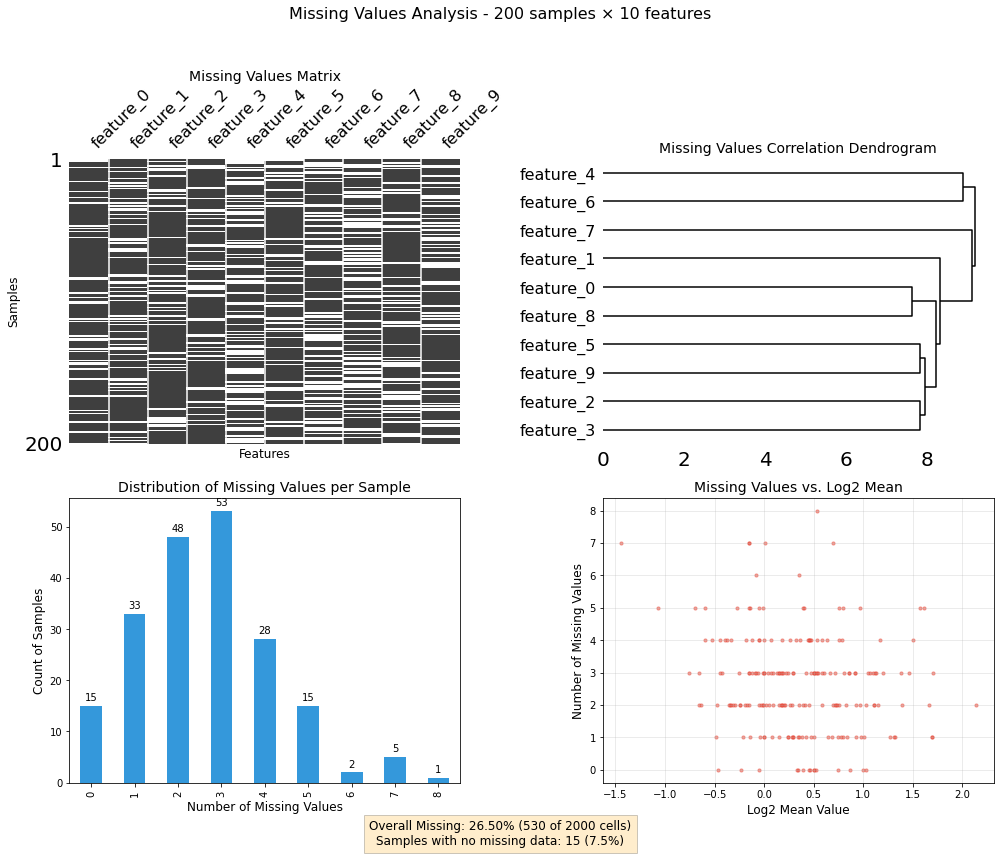

In [ ]:
# Create a missing values analyzer
mv_analyzer = MissingValuesAnalyzer(sample_df)

# Generate the dashboard
fig, axes, summary = mv_analyzer.plot_missing_dashboard()

## Group-Based MinProb Imputation for Proteomics Data


> Overview

This utility implements a specialized imputation strategy for proteomics data that handles missing values in a biologically meaningful way. The approach is based on the MinProb imputation strategy commonly used in proteomics analysis, but with modifications to work on a condition group basis.


### Imputation Strategy

The imputation follows these key principles:
- Condition-Based Statistics: For each experimental condition group, the algorithm computes distribution statistics by pooling all values across replicates and proteins.
- Selective Imputation: Missing values are only imputed when all measurements for a protein within a specific condition group are missing. This approach is ideal for handling proteins that are completely undetected in certain conditions.
- Low-Intensity Replacement: Following the MinProb philosophy, missing values are imputed as low-intensity signals, drawn from a normal distribution centered at a low quantile of the observed values.

In [ ]:
#| export
def group_based_minprob_impute(df, group_vector, quantile=0.0001, sd_factor=0.2, random_state=None):
    """
    Group-based MinProb imputation for proteomics data.
    First computes quantile distribution statistics for each condition group by merging all values
    within the condition. Then imputes missing values only for rows where all values in a particular
    condition are missing by drawing random values from the calculated distribution.
    
    Parameters:
      df (pd.DataFrame): Input DataFrame in log space (rows: proteins, columns: samples)
      group_vector (list): Vector indicating group membership of each column
      quantile (float): Quantile to use as the center for the imputation (default: 0.01)
      sd_factor (float): Factor to multiply the standard deviation for noise level (default: 0.2)
      random_state (int, optional): Random seed for reproducibility
      
    Returns:
      pd.DataFrame: DataFrame with imputed missing values.
    """
    # Set random seed if provided
    if random_state is not None:
        np.random.seed(random_state)
    
    # Verify group_vector length matches df columns
    if len(group_vector) != df.shape[1]:
        raise ValueError(f"Length of group_vector ({len(group_vector)}) must match number of columns in df ({df.shape[1]})")
    
    # Convert group_vector to numpy array for easier manipulation
    group_vector = np.array(group_vector)
    
    # Get unique groups
    unique_groups = np.unique(group_vector)
    
    # Create a copy of the dataframe to avoid modifying the original
    imputed_df = df.copy()
    
    # Step 1: Compute quantile distribution statistics for each condition group
    print("Computing condition statistics:")
    condition_stats = {}
    for group in unique_groups:
        # Get all values from this condition group
        group_cols = np.where(group_vector == group)[0]
        group_data = df.iloc[:, group_cols].values.flatten()
        
        # Remove NaN values
        group_data = group_data[~np.isnan(group_data)]
        
        if len(group_data) > 0:
            # Calculate statistics for this condition
            condition_stats[group] = {
                'low_center': np.quantile(group_data, quantile),
                'noise_sd': sd_factor * np.std(group_data) if len(group_data) > 1 else sd_factor * 0.1
            }
            print(f"  Condition {group}: {len(group_data)} valid values, center={condition_stats[group]['low_center']:.4f}, "
                  f"noise_sd={condition_stats[group]['noise_sd']:.4f}")
        else:
            print(f"  Warning: Condition {group} has no valid data for computing statistics")
    
    # Step 2: Process each row and impute missing values
    print("\nImputing missing values:")
    imputation_count = 0
    
    for i in range(len(imputed_df)):
        row = imputed_df.iloc[i]
        row_imputed = False
        
        # Check each group for this row
        for group in unique_groups:
            # Get column indices for current group
            group_cols = np.where(group_vector == group)[0]
            
            # Get values for this row in the current group
            group_values = row.iloc[group_cols]
            
            # Check if ALL values in this group are NaN for this row
            if group_values.isna().all():
                if group not in condition_stats:
                    print(f"  Cannot impute condition {group} for row {i} (index: {imputed_df.index[i]}) - no statistics available")
                    continue
                    
                # Get the pre-computed statistics for this condition
                low_center = condition_stats[group]['low_center']
                noise_sd = condition_stats[group]['noise_sd']
                
                # Generate random values for imputation
                imputed_values = np.random.normal(
                    loc=low_center, 
                    scale=noise_sd, 
                    size=len(group_cols)
                )
                
                # Clip values to be at most the low center (keeping them as low signals)
                imputed_values = np.minimum(imputed_values, low_center)
                
                # Assign imputed values to the group columns for this row
                for j, col_idx in enumerate(group_cols):
                    imputed_df.iat[i, col_idx] = imputed_values[j]
                
                row_imputed = True
                imputation_count += len(group_cols)
        
        if row_imputed:
            print(f"  Imputed missing values for row {i} (index: {imputed_df.index[i]})")
    
    print(f"\nImputation complete: {imputation_count} values imputed across {len(imputed_df)} rows")
    return imputed_df


## Usage example

In [ ]:
# Create a toy DataFrame in log2 space
np.random.seed(42)
data = np.log2(np.random.rand(10, 5) * 1e4)
df_example = pd.DataFrame(data, columns=[f'Sample{i+1}' for i in range(5)])

# Define condition groups: first 3 columns are group 1, last 2 columns are group 2
groups = [1, 1, 1, 2, 2]

# Introduce missing values by groups
# Make all values in group 1 missing for row 2
df_example.iloc[2, 0:3] = np.nan

# Make all values in group 2 missing for row 5
df_example.iloc[5, 3:5] = np.nan

print("Before imputation:")
print(df_example)
print("\nGroup vector:", groups)

# Apply the imputation
imputed_df = group_based_minprob_impute(df_example, groups, random_state=42)

print("\nAfter imputation:")
print(imputed_df)
#selection_normed = group_based_minprob_impute(np.log2(df).copy(), group_vector=[1,1,1,2,2,3,3,4,4,4,5,5,5])

Before imputation:
     Sample1    Sample2    Sample3    Sample4    Sample5
0  11.870905  13.214796  12.837616  12.547518  10.607503
1  10.607280   9.181987  13.080445  12.553425  12.789682
2        NaN        NaN        NaN  11.052154  10.828335
3  10.840813  11.571005  12.357432  12.076632  11.507939
4  12.578969  10.445986  11.512467  11.839054  12.155040
5  12.938800  10.963429  12.328211        NaN        NaN
6  12.568775  10.735760   9.345441  13.212018  13.237258
7  12.980849  11.572765   9.931803  12.740272  12.103788
8  10.253118  12.273728   8.425783  13.150573  11.337510
9  12.693753  11.605994  12.344485  12.416561  10.852174

Group vector: [1, 1, 1, 2, 2]
Computing condition statistics:
  Condition 1: 27 valid values, center=8.4277, noise_sd=0.2576
  Condition 2: 18 valid values, center=10.6079, noise_sd=0.1666

Imputing missing values:
  Imputed missing values for row 2 (index: 2)
  Imputed missing values for row 5 (index: 5)

Imputation complete: 5 values imputed across 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()